# 包导入与数据读取

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

import jieba
from collections import Counter
from wordcloud import WordCloud
from snownlp import SnowNLP

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 用来正常显示中文标签
plt.rcParams['figure.figsize']=[16,12] 
pd.set_option('display.max_columns', 80) 
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [57]:
# 读取数据
df = pd.read_csv('data.csv')

# 转换日期列为datetime类型
df['born_data'] = pd.to_datetime(df['born_data'])
df['death_data'] = pd.to_datetime(df['death_data'])

# 计算存活天数
df['live_days'] = (df['death_data'] - df['born_data']).dt.days

# 显示基本信息
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272 entries, 0 to 6271
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   bianh         6272 non-null   int64         
 1   com_name      6272 non-null   object        
 2   com_addr      6272 non-null   object        
 3   cat           6272 non-null   object        
 4   se_cat        6271 non-null   object        
 5   com_des       6271 non-null   object        
 6   born_data     6272 non-null   datetime64[ns]
 7   death_data    6272 non-null   datetime64[ns]
 8   live_days     6272 non-null   int64         
 9   financing     6272 non-null   object        
 10  total_money   805 non-null    float64       
 11  death_reason  1419 non-null   object        
 12  invest_name   600 non-null    object        
 13  ceo_name      4839 non-null   object        
 14  ceo_des       4838 non-null   object        
 15  ceo_per_des   4839 non-null   object  

# 数据清洗

In [58]:
# 查看数据重复
print(df.duplicated().sum())


0


In [59]:
# 查看数据缺失
print(df.isnull().sum())

bianh              0
com_name           0
com_addr           0
cat                0
se_cat             1
com_des            1
born_data          0
death_data         0
live_days          0
financing          0
total_money     5467
death_reason    4853
invest_name     5672
ceo_name        1433
ceo_des         1434
ceo_per_des     1433
Unnamed: 16     6272
Unnamed: 17     6272
Unnamed: 18     6272
Unnamed: 19     6272
Unnamed: 20     6272
dtype: int64


In [60]:
# 删除 Unnamed: 16-20 列
df = df.drop(columns=['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20'])



In [61]:
a=df['com_name'].value_counts().sort_values(ascending=False)

In [62]:
df.loc[df['com_name']=='秘密花园']

,bianh,com_name,com_addr,cat,se_cat,com_des,born_data,death_data,live_days,financing,total_money,death_reason,invest_name,ceo_name,ceo_des,ceo_per_des
215,22,秘密花园,上海,社交网络,婚恋交友,秘密花园，基于地理位置，解决用户情感问题的共享互助社区。隶属于上海薇翔网络科技发展有限公司。,2015-02-01,2019-06-01,1581,尚未获投,NaN,NaN,NaN,宋一,创始人,宋一（秘密花园创始人）： 2002年上海爱诺建筑工程有限公司 法人 设计师 2008年上海金...
5383,539,秘密花园,上海,电子商务,综合电商,秘密花园是一个女性服务网站，让用户与可以交流分享秘密，而后转型做情趣用品电商。,2013-06-01,2015-07-25,784,不明确,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# 打印 df['live_days']为负数的记录
print(df[df['live_days'] < 0])


      bianh com_name com_addr   cat  se_cat  \
6269    627    3C物联网       上海  企业服务  IT基础设施   

                                               com_des  born_data death_data  \
6269  3C物联网是一家物联网技术服务公司。致力于为企业提供物联服务。隶属于上海善习物联网科技有限公司。 2013-04-01 2000-08-11   

      live_days financing  total_money death_reason invest_name ceo_name  \
6269      -4616       不明确          NaN          NaN         NaN       徐飞   

     ceo_des ceo_per_des  
6269     CEO   3C物联网CEO。  


In [64]:
df.describe()['live_days']/365

count    17.183562
mean      3.574132
min     -12.646575
25%       2.342466
50%       3.071233
75%       4.586301
max      23.621918
std       1.772587
Name: live_days, dtype: float64

# 数据探索(EDA)

### 公司地理分布

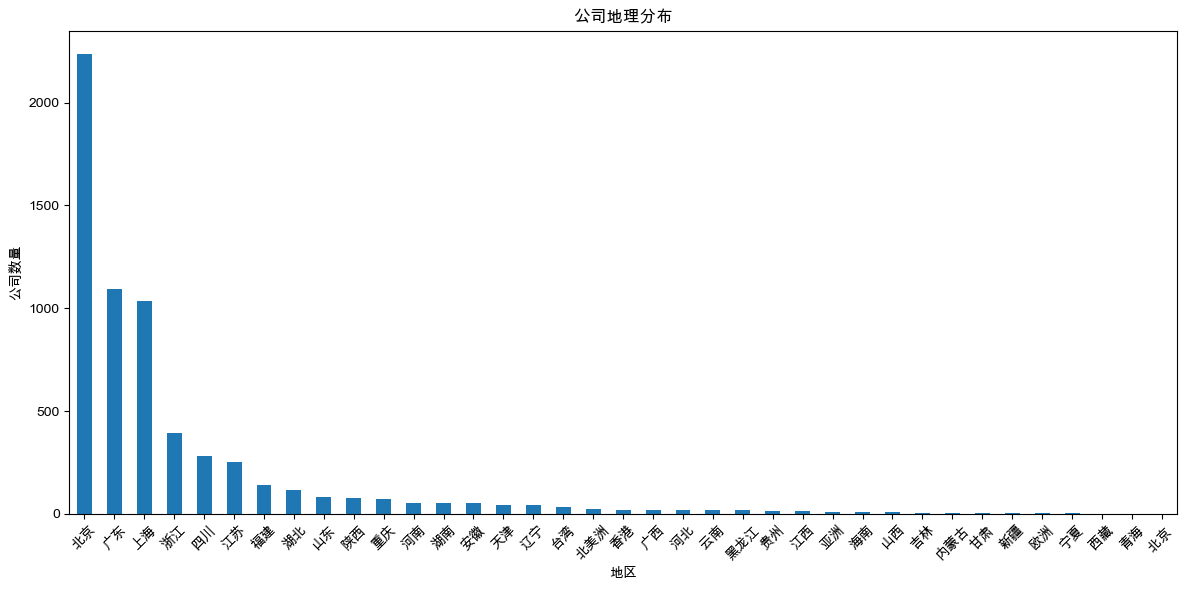

In [65]:
# 公司地理分布
plt.figure(figsize=(12, 6))
df['com_addr'].value_counts().plot(kind='bar')
plt.title('公司地理分布')
plt.xlabel('地区')
plt.ylabel('公司数量')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 公司成立时间分布

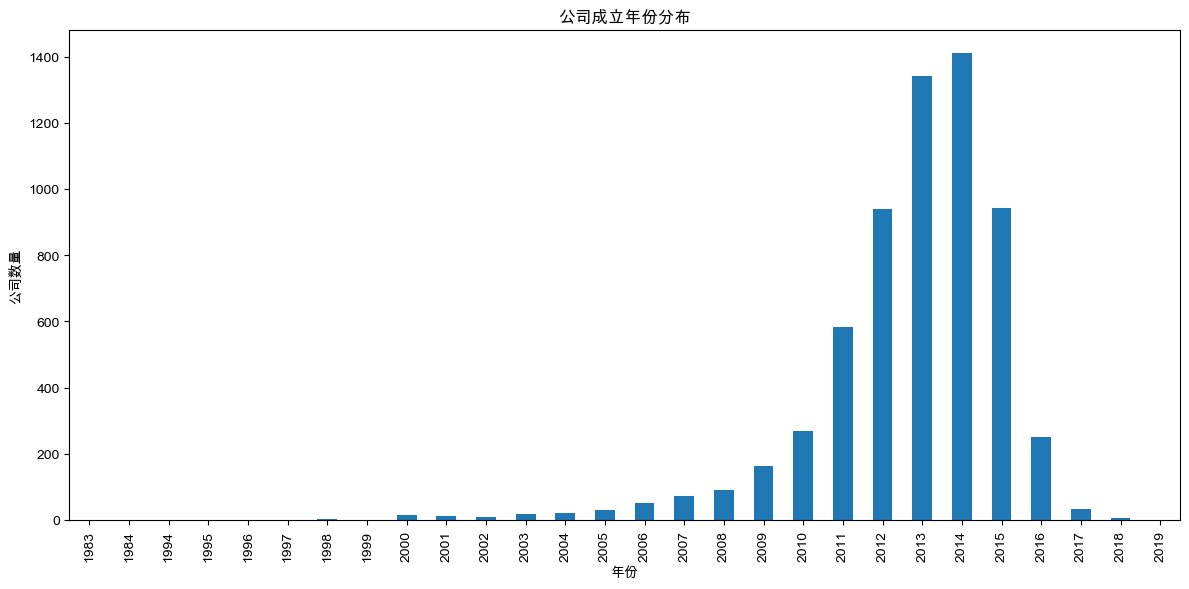

In [66]:
# 公司成立时间分布
df['born_year'] = pd.to_datetime(df['born_data']).dt.year
plt.figure(figsize=(12, 6))
df['born_year'].value_counts().sort_index().plot(kind='bar')
plt.title('公司成立年份分布')
plt.xlabel('年份')
plt.ylabel('公司数量')
plt.tight_layout()
plt.show()

## 公司存活时间分析

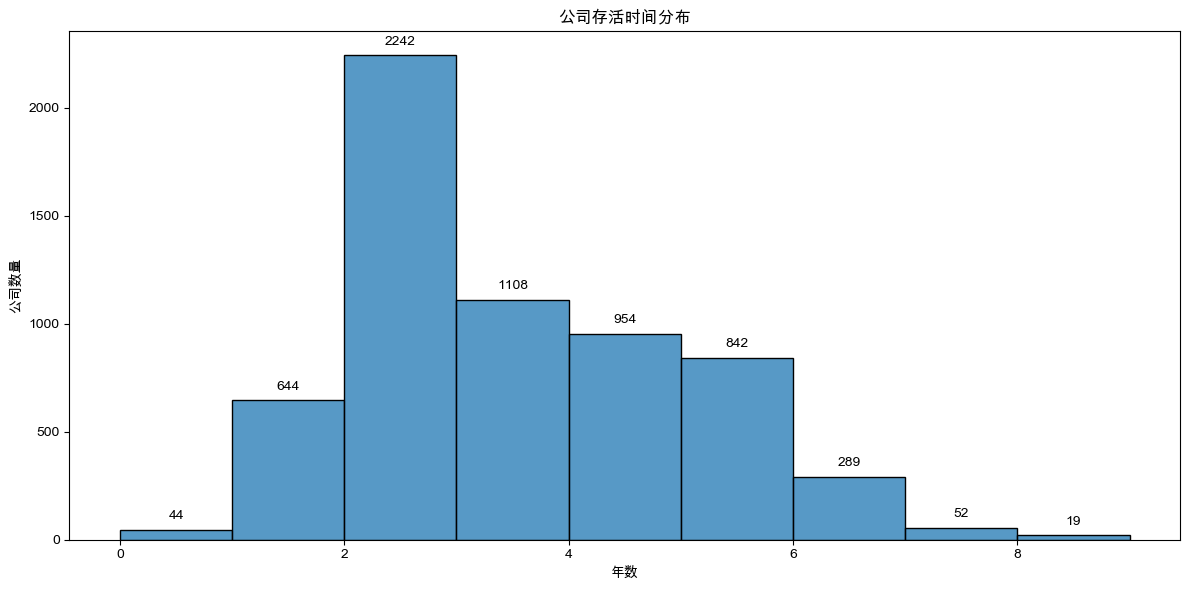

count    6211.000000
mean        3.484508
std         1.469520
min         0.331507
25%         2.341096
50%         3.065753
75%         4.523288
max         9.997260
Name: live_years, dtype: float64


In [67]:
# 公司存活时间分析
df['live_years'] = (pd.to_datetime(df['death_data']) - pd.to_datetime(df['born_data'])).dt.days / 365
df = df[(df['live_years'] > 0) & (df['live_years'] <= 10)]  # 丢掉 0 以下和 10 以上的值
plt.figure(figsize=(12, 6))
ax = sns.histplot(df['live_years'], bins=range(0, int(df['live_years'].max()) + 1))  # 数据桶定义成 1 年
plt.title('公司存活时间分布')
plt.xlabel('年数')
plt.ylabel('公司数量')

# 在柱状图上标注对应的数字
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

print(df['live_years'].describe())


## 行业分析


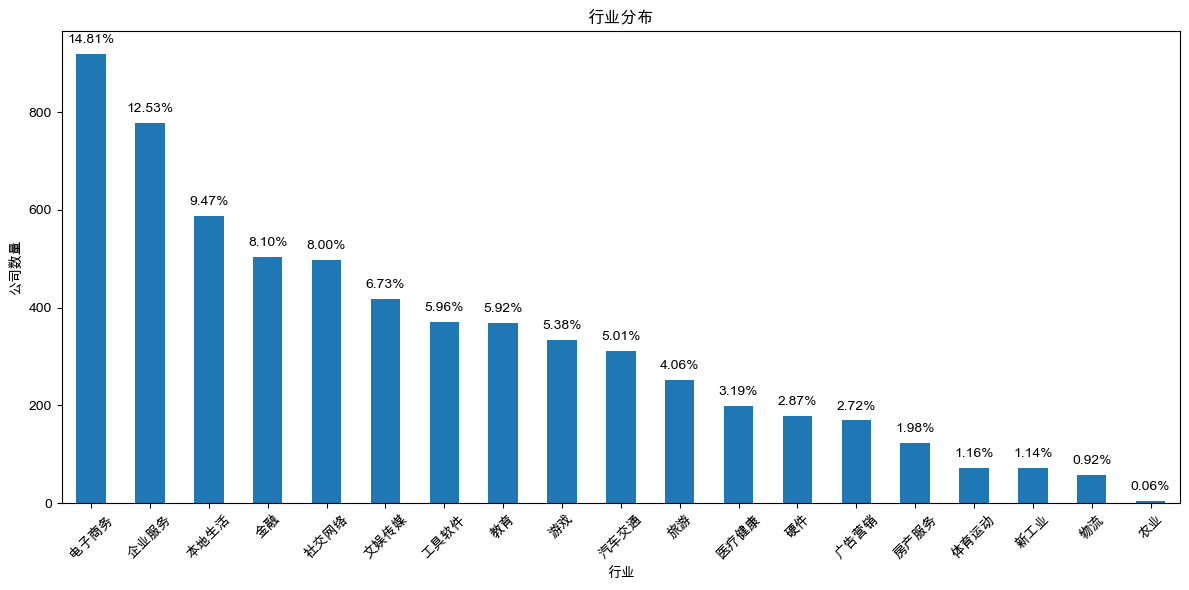

In [68]:
plt.figure(figsize=(12, 6))
ax = df['cat'].value_counts().plot(kind='bar')
plt.title('行业分布')
plt.xlabel('行业')
plt.ylabel('公司数量')
plt.xticks(rotation=45)

# 在柱状图上标注对应的占比
total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{height / total:.2%}'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

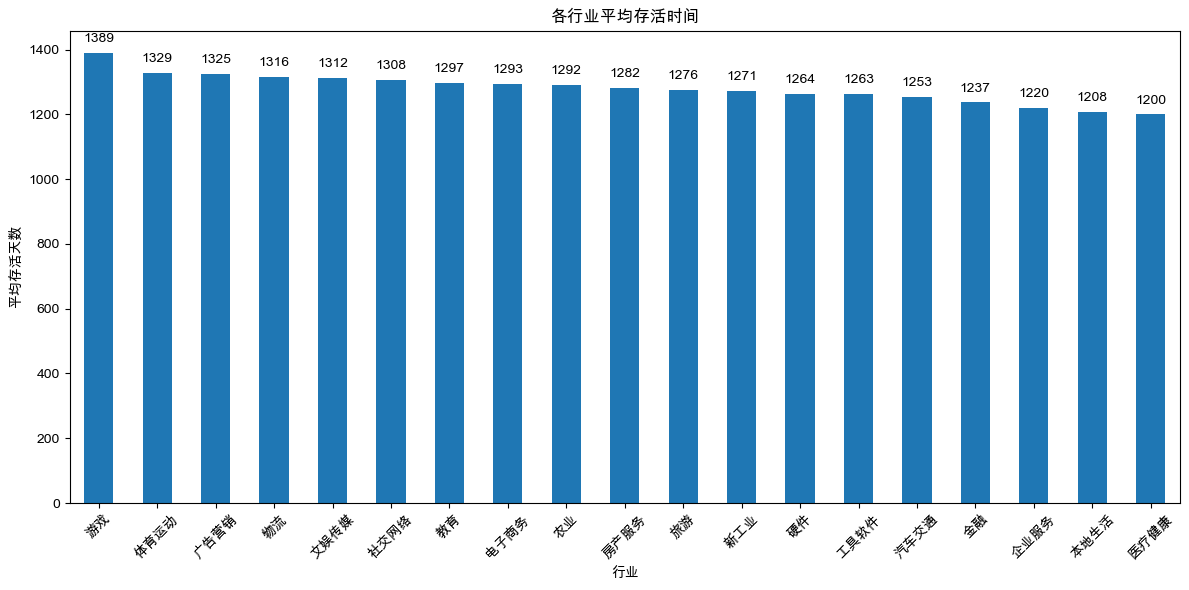

In [75]:
# 各行业平均存活时间对比
industry_lifetime = df.groupby('cat')['live_days'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
ax = industry_lifetime.plot(kind='bar')
plt.title('各行业平均存活时间')
plt.xlabel('行业')
plt.ylabel('平均存活天数')
plt.xticks(rotation=45)

# 在柱状图上标注对应的数值
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{round(height)}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

## 融资情况分析

In [123]:
# 3. 融资情况分析

# 融资轮次分布
from pyecharts.charts import Bar
from pyecharts import options as opts

financing_counts = df['financing'].value_counts()
bar = (
    Bar()
    .add_xaxis(financing_counts.index.tolist())
    .add_yaxis("公司数量", financing_counts.values.tolist(), label_opts=opts.LabelOpts(position="top"))
    .set_global_opts(
        title_opts=opts.TitleOpts(title="融资轮次分布", title_textstyle_opts=opts.TextStyleOpts(font_size=20)),
        xaxis_opts=opts.AxisOpts(name="融资轮次", axislabel_opts=opts.LabelOpts(rotate=45), splitline_opts=opts.SplitLineOpts(is_show=False)),
        yaxis_opts=opts.AxisOpts(name="公司数量", splitline_opts=opts.SplitLineOpts(is_show=False)),
        toolbox_opts=opts.ToolboxOpts(),
        legend_opts=opts.LegendOpts(is_show=False)
    )
)
bar.render_notebook()



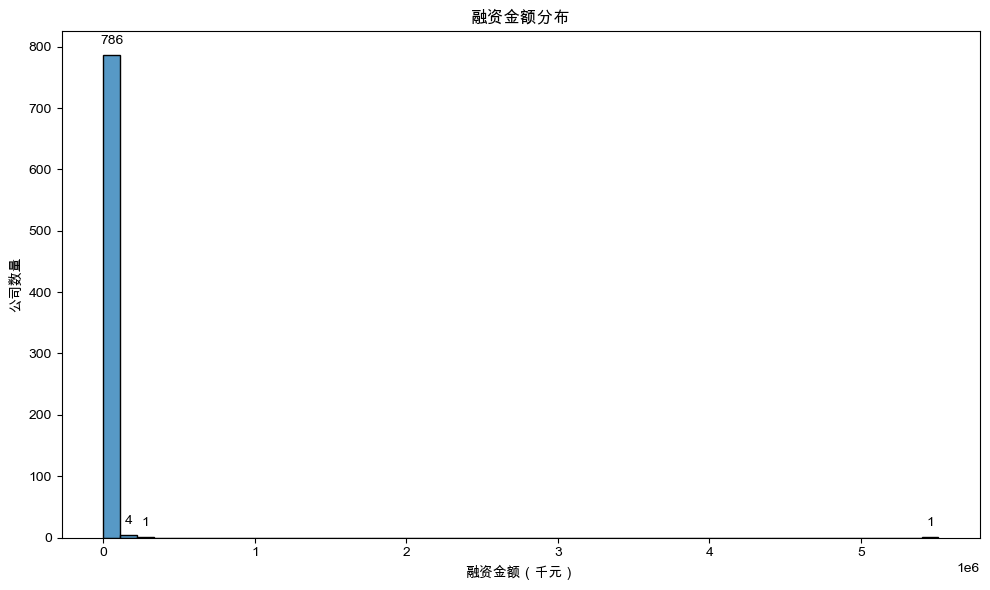

In [70]:
# 融资金额分析
plt.figure(figsize=(10, 6))
ax = sns.histplot(df['total_money'].dropna(), bins=50)
plt.title('融资金额分布')
plt.xlabel('融资金额（千元）')
plt.ylabel('公司数量')

# 在柱状图上标注对应的数值
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # 只标注大于0的数值
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

## 失败原因分析

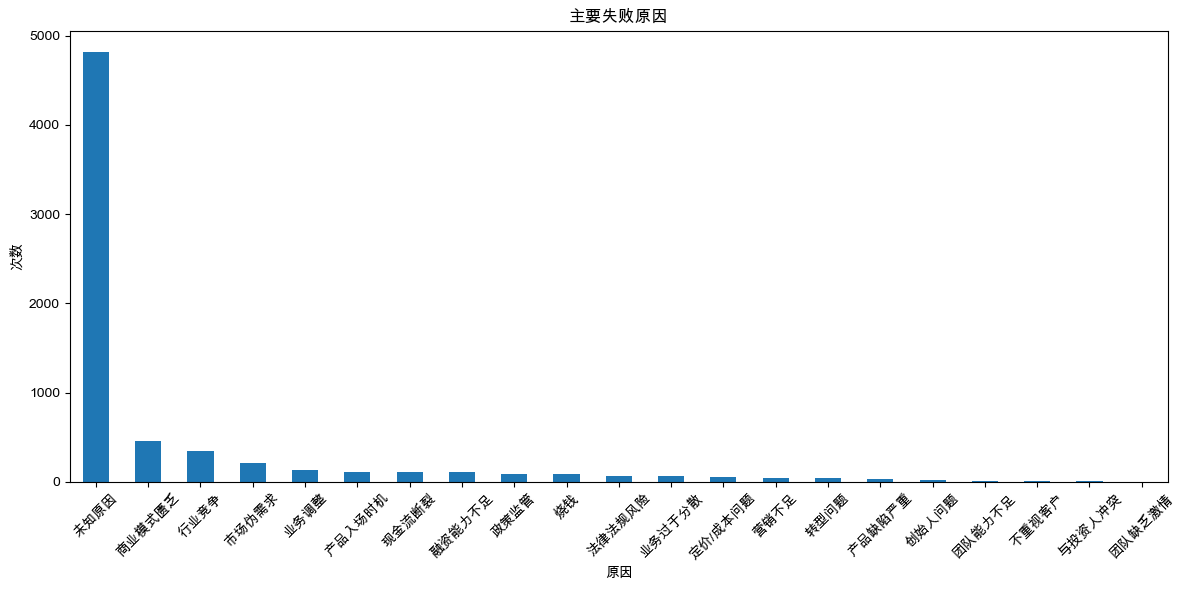

In [119]:
# 主要失败原因统计
reasons = df['death_reason'].str.split().explode()
reason_counts = reasons.value_counts()
plt.figure(figsize=(12, 6))
reason_counts.plot(kind='bar')
plt.title('主要失败原因')
plt.xlabel('原因')
plt.ylabel('次数')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

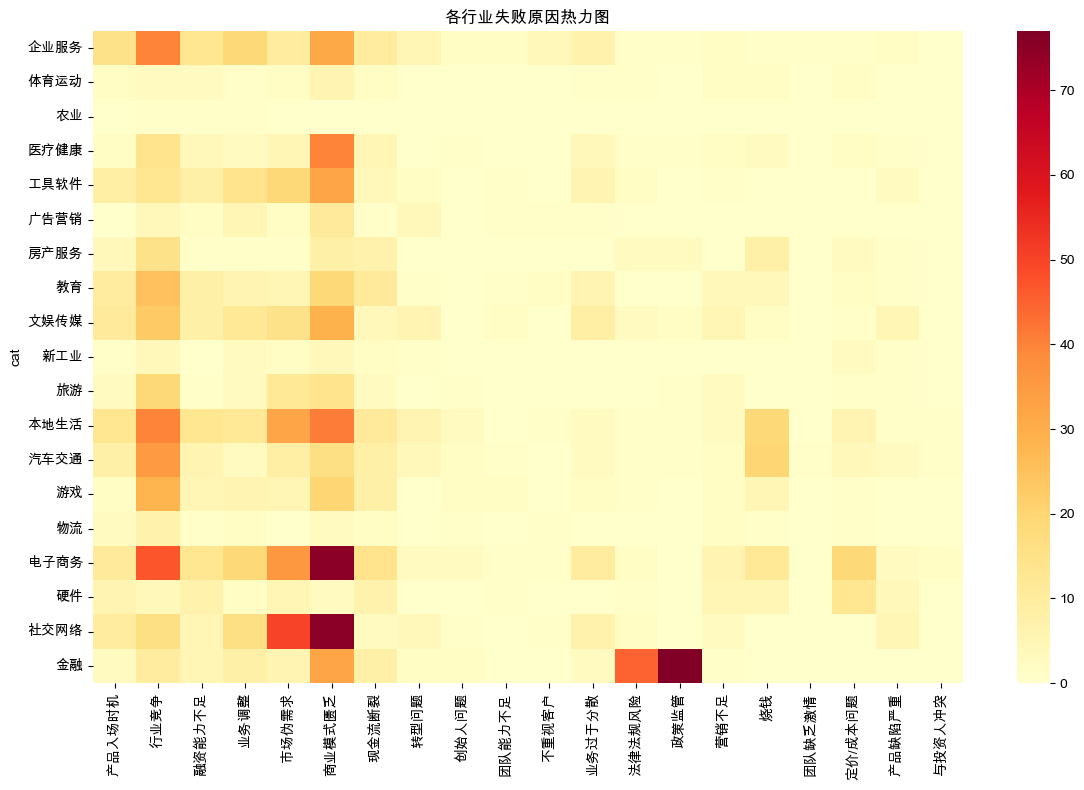

In [72]:
# 失败原因与行业的关系

df['death_reason'] = df['death_reason'].fillna('未知原因')
df['death_reason'] = df['death_reason'].astype(str)
industry_reasons = df[df['death_reason'] != '未知原因'].groupby('cat')['death_reason'].apply(lambda x: ' '.join(x)).str.split()
industry_reason_counts = industry_reasons.apply(Counter)
top_reasons = pd.DataFrame(industry_reason_counts.tolist(), index=industry_reason_counts.index).fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(top_reasons, cmap='YlOrRd')
plt.title('各行业失败原因热力图')
plt.tight_layout()
plt.show()

In [144]:
top_reasons

,产品入场时机,行业竞争,融资能力不足,业务调整,市场伪需求,商业模式匮乏,现金流断裂,转型问题,创始人问题,团队能力不足,不重视客户,业务过于分散,法律法规风险,政策监管,营销不足,烧钱,团队缺乏激情,定价/成本问题,产品缺陷严重,与投资人冲突
cat,,,,,,,,,,,,,,,,,,,,
企业服务,15.0,40,13.0,19,10.0,31.0,10.0,5.0,2.0,2.0,4.0,7.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0
体育运动,2.0,3,3.0,1,2.0,6.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0
农业,0.0,1,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
医疗健康,2.0,14,4.0,3,5.0,40.0,5.0,0.0,1.0,0.0,0.0,4.0,1.0,1.0,2.0,3.0,0.0,2.0,1.0,0.0
工具软件,9.0,13,8.0,14,19.0,32.0,4.0,2.0,0.0,1.0,0.0,6.0,2.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0
广告营销,0.0,4,2.0,5,2.0,11.0,1.0,4.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
房产服务,4.0,15,1.0,1,1.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,8.0,0.0,3.0,1.0,0.0
教育,10.0,25,8.0,6,5.0,19.0,11.0,1.0,0.0,1.0,2.0,6.0,0.0,0.0,4.0,4.0,0.0,2.0,1.0,0.0
文娱传媒,11.0,23,8.0,12,15.0,29.0,4.0,6.0,0.0,2.0,0.0,9.0,3.0,2.0,5.0,2.0,0.0,1.0,5.0,0.0


## 创始人分析

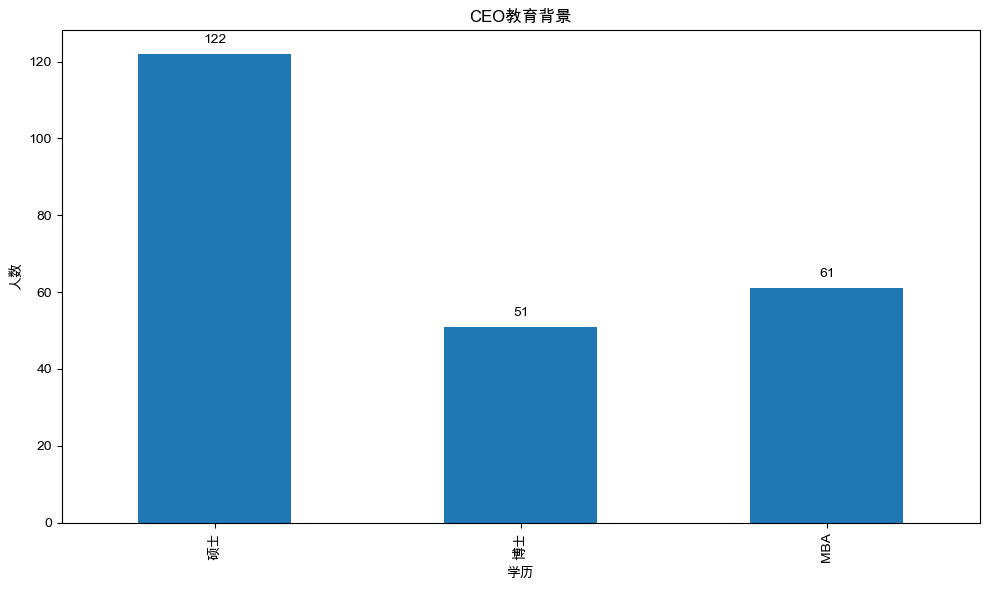

In [126]:
education_keywords = ['硕士', '博士', 'MBA']
for keyword in education_keywords:
    df[keyword] = df['ceo_per_des'].str.contains(keyword, na=False)
plt.figure(figsize=(10, 6))
ax = df[education_keywords].sum().plot(kind='bar')
plt.title('CEO教育背景')
plt.xlabel('学历')
plt.ylabel('人数')

# 在柱状图上标注对应的数值
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # 只标注大于0的数值
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

In [127]:
# 分析 df['ceo_per_des'] 列


# 统计 CEO 描述中提到的关键词
stopwords = set(['；','）','公司','有限公司','（','曾','网','年',' ','、','。','，','的', '和', '是', '在', '了', '与', '及', '也', '有', '对', '就', '都', '而', '并', '等', '中', '与', '为', '上', '下', '于', '他', '她', '它', '我们', '你们', '他们', '她们', '它们'])
all_words = []
for desc in df['ceo_per_des'].dropna():
    words = jieba.lcut(desc, cut_all=False, HMM=True)
    all_words.extend([word for word in words if word not in stopwords])

word_counts = Counter(all_words)
top_words = word_counts.most_common(100)

print("Top 100 关键词:", top_words)





是否包含 '硕士': True
Top 100 关键词: [('创始人', 4025), ('CEO', 1890), ('科技', 1292), ('北京', 950), ('联合', 532), ('上海', 471), ('工作', 397), ('担任', 374), ('产品', 367), ('网络科技', 355), ('总经理', 350), ('创业者', 344), ('互联网', 330), ('连续', 324), ('创业', 323), ('执行', 312), ('毕业', 311), ('董事', 308), ('经验', 298), ('此前', 280), ('网络', 279), ('兼', 276), ('技术', 260), ('管理', 251), ('深圳市', 246), ('董事长', 245), ('中国', 236), ('创办', 231), ('信息', 217), ('总监', 216), ('运营', 211), ('行业', 204), ('投资', 202), ('经理', 199), ('”', 187), ('后', 186), ('“', 185), ('信息技术', 181), ('负责', 164), ('集团', 156), (',', 151), ('人', 147), ('杭州', 143), ('服务', 140), ('(', 138), (')', 138), ('深圳', 137), ('项目', 132), ('创立', 130), ('企业', 129), ('金融', 128), ('软件', 128), ('团队', 128), ('开始', 126), ('市场', 124), ('从事', 122), ('月', 118), ('.', 117), ('平台', 112), ('领域', 112), ('任职', 112), ('过', 108), ('移动', 108), ('开发', 107), ('发展', 107), ('文化', 104), ('教育', 103), ('多年', 103), ('前', 100), ('咨询', 98), ('大学', 98), ('电子商务', 98), ('成都', 96), ('硕士', 95), ('美国', 95

In [117]:
# 词云可视化

from pyecharts.charts import WordCloud
from pyecharts import options as opts

# 生成词云
wordcloud = WordCloud()
wordcloud.add("", top_words, word_size_range=[20, 100], shape='circle')
wordcloud.set_global_opts(title_opts=opts.TitleOpts(title="词云可视化"))

# 渲染词云
wordcloud.render_notebook()

## 投资机构分析

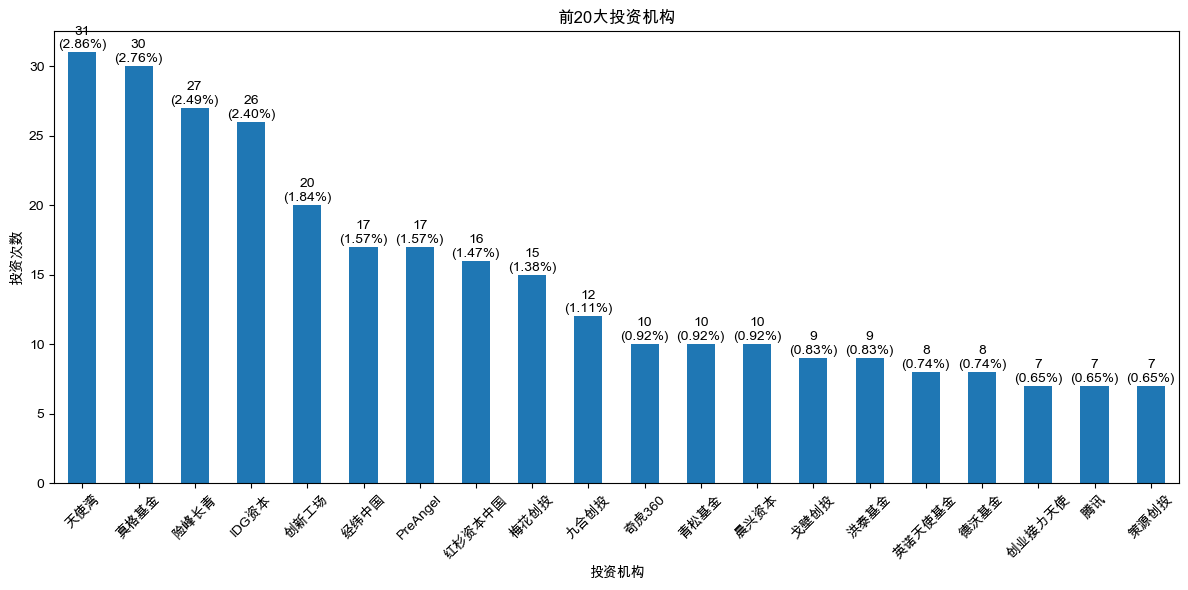

In [133]:
# 主要投资机构统计
investors = df['invest_name'].str.split('&').explode()
investor_counts = investors.value_counts()
top_20_investors = investor_counts.head(20)
total_investments = investor_counts.sum()

plt.figure(figsize=(12, 6))
ax = top_20_investors.plot(kind='bar')
plt.title('前20大投资机构')
plt.xlabel('投资机构')
plt.ylabel('投资次数')
plt.xticks(rotation=45)

# 在柱状图上显示数值和占比
for p in ax.patches:
    height = p.get_height()
    percentage = height / total_investments * 100
    ax.annotate(f'{height}\n({percentage:.2f}%)', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

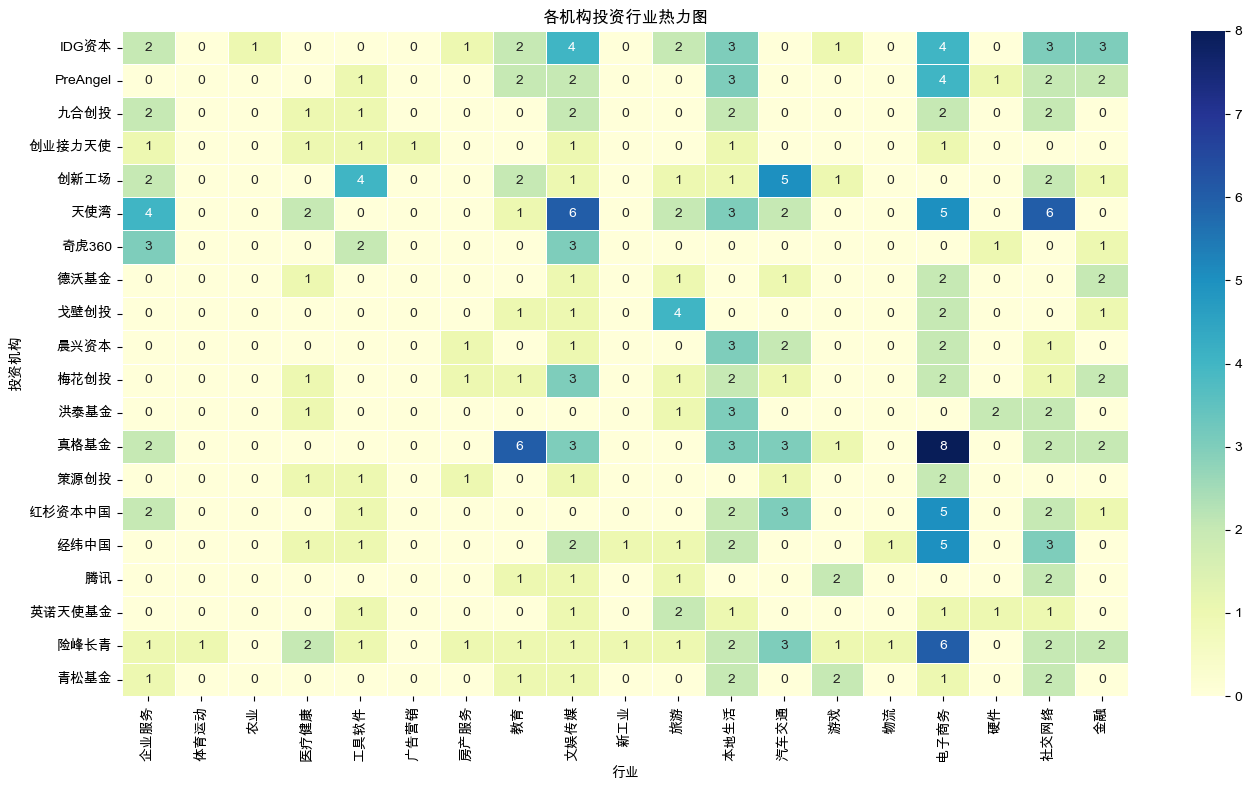

In [146]:
# 分析 top_20_investors 和行业的关联
# 创建一个投资机构和行业的交叉表
top_20_investors_list = top_20_investors.index.tolist()
investor_industry = df['invest_name'].str.split('&').explode().reset_index()
investor_industry = investor_industry[investor_industry['invest_name'].isin(top_20_investors_list)]
investor_industry = investor_industry.merge(df.reset_index()[['index', 'cat']], on='index')
investor_industry_table = pd.crosstab(investor_industry['invest_name'], investor_industry['cat'])

# 使用 seaborn 绘制热力图
plt.figure(figsize=(14, 8))
sns.heatmap(investor_industry_table, cmap='YlGnBu', linewidths=.5, annot=True, fmt="d")
plt.title('各机构投资行业热力图')
plt.xlabel('行业')
plt.ylabel('投资机构')
plt.tight_layout()
plt.show()


## 时间序列分析


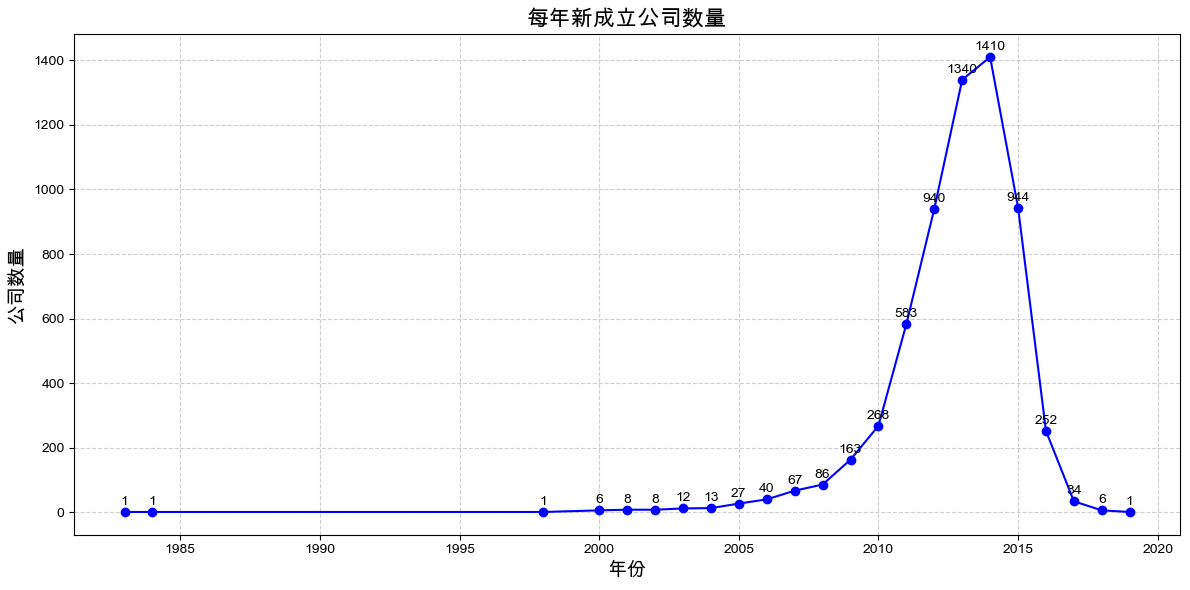

In [151]:
# 公司成立数量的时间趋势
df['born_year'] = pd.to_datetime(df['born_data']).dt.year
yearly_foundings = df['born_year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
ax = yearly_foundings.plot(marker='o', linestyle='-', color='b')
plt.title('每年新成立公司数量', fontsize=16)
plt.xlabel('年份', fontsize=14)
plt.ylabel('公司数量', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# 在折线图上标注关键数值
for x, y in yearly_foundings.items():
    ax.annotate(f'{y}', xy=(x, y), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

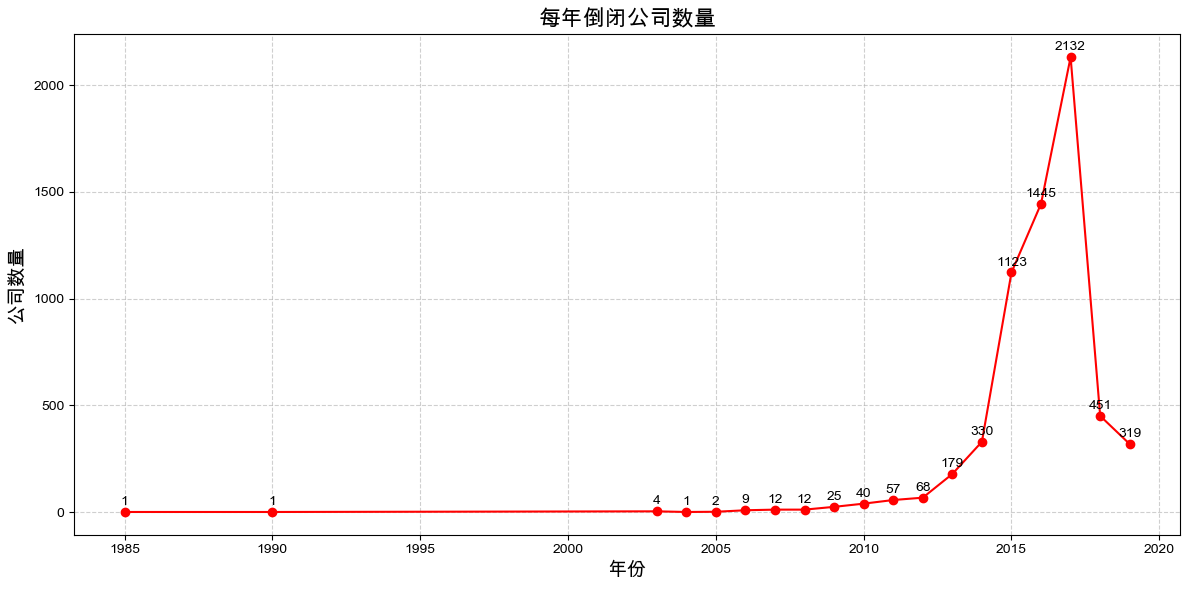

In [153]:
# 公司倒闭数量的时间趋势
df['death_year'] = pd.to_datetime(df['death_data']).dt.year
yearly_deaths = df['death_year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
ax = yearly_deaths.plot(marker='o', linestyle='-', color='r')
plt.title('每年倒闭公司数量', fontsize=16)
plt.xlabel('年份', fontsize=14)
plt.ylabel('公司数量', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# 在折线图上标注关键数值
for x, y in yearly_deaths.items():
    ax.annotate(f'{y}', xy=(x, y), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


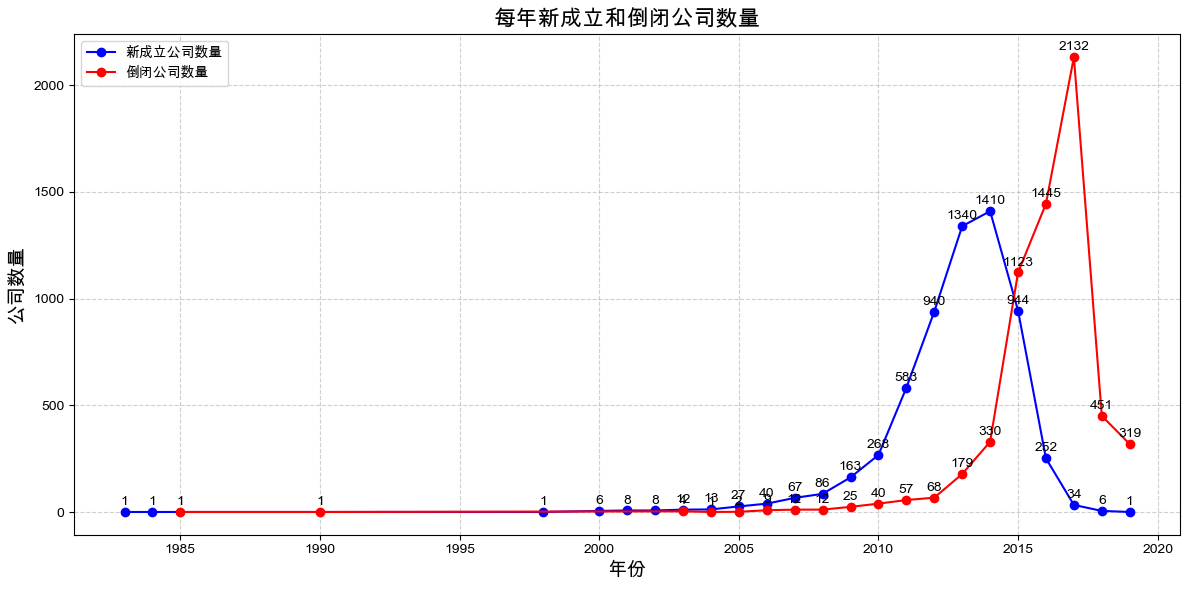

In [154]:
# 公司成立和倒闭数量的时间趋势结合分析
df['born_year'] = pd.to_datetime(df['born_data']).dt.year
df['death_year'] = pd.to_datetime(df['death_data']).dt.year

yearly_foundings = df['born_year'].value_counts().sort_index()
yearly_deaths = df['death_year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
ax1 = yearly_foundings.plot(marker='o', linestyle='-', color='b', label='新成立公司数量')
ax2 = yearly_deaths.plot(marker='o', linestyle='-', color='r', label='倒闭公司数量')

plt.title('每年新成立和倒闭公司数量', fontsize=16)
plt.xlabel('年份', fontsize=14)
plt.ylabel('公司数量', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# 在折线图上标注关键数值
for x, y in yearly_foundings.items():
    ax1.annotate(f'{y}', xy=(x, y), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10, color='black')
for x, y in yearly_deaths.items():
    ax2.annotate(f'{y}', xy=(x, y), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


通过对公司新成立和倒闭的时间序列分析，我们得出以下具体结论：

1. **公司新成立数量的时间趋势**显示，**2014年至2016年**是创业公司的高速增长期，尤其是**2015年**，新成立公司的数量达到了峰值。这反映了当时市场对创业的高度热情和资本市场的活跃。

2. **公司倒闭数量的时间趋势**显示，**2017年和2018年**倒闭公司的数量显著增加，特别是**2018年**，倒闭数量达到了高峰。这可能与市场环境变化、资本寒冬以及行业竞争加剧等因素有关。

3. **新成立和倒闭公司的数量对比**显示，**2015年**新成立公司的数量远远超过倒闭公司的数量，表明市场处于快速扩张阶段。然而，到**2018年**，倒闭公司的数量接近甚至超过了新成立公司的数量，表明市场进入了调整和洗牌期。

4. **趋势分析表明**，创业公司的兴衰与宏观经济环境和行业周期密切相关。创业者应当关注市场动态，合理规划，避免在市场高风险时期盲目扩张。
